In [1]:
# Mount to drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Link to the directory of folder.
%cd /content/drive/MyDrive/hanlhn/Problem

/content/drive/.shortcut-targets-by-id/1xP_CCNA2iBFpmQU0YLdkhiDjQ9ZvTNtW/hanlhn/Problem


In [3]:
#!unzip 'problem2-data/archive.zip' 

In [4]:
import os
import numpy as np
import cv2
import torch
import random
import queue
from itertools import cycle
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from tqdm import tqdm
import multiprocessing
import torchvision.models as models
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
class CFG:
    '''
    CFG
    Define hyperparameters used for preprocessing data and training model
    ----------
    Attributes
    ----------
        num_epochs: int 
            Number of epochs need for training.
        batch_size: int
            Number of samples used for training in 1 iteration.
        mean: ndarray
            Mean values of the whole dataset
        std: ndarray
            Standard deviation values of the whole dataset.
        height: int
            Height of input image used for the input layer of model.
        width: int
            Width of input image used for the input layer of model.
        learning_rate: float
            Step size at each iteration defines how much to change the model.
        num_classes: int
            Number of output classes.
        target_names: list(str) 
            Names of output classes.
    '''
    num_epochs = 10
    batch_size = 32
    num_workers = 2
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    height = 224
    width = 224
    learning_rate = 0.001
    num_classes = 4
    path = 'data'
    stoi = {'cloudy' : 0, 'desert' : 1, 'green_area' : 2, 'water' : 3}
    itos = {0 :'cloudy', 1 : 'desert', 2 : 'green_area', 3 : 'water'}
    target_names = ['cloudy', 'desert', 'green_area', 'water']

In [7]:
def random_split_dataset(path = CFG.path):
    '''
    random_split_dataset(path = CFG.path)
    Split the dataset into 3 subsets included: train, validation and test.
    ----------
    Parameters
    ----------
    path : str, default=CFG.path
        `path` define the path to dataset
    ----------
    Returns
    ----------
    tuple(list(str))
        Tuple including 3 lists: train, validation, test. Each list contains paths to samples in dataset.
        The default ratio for 3 subset: train=0.6, validation=0.2, test=0.2
    '''
    data = []
    for classname in os.listdir(path):
        for filename in os.listdir(os.path.join(path, classname)):
            data.append((filename, classname))
    print('Length dataset', len(data))
    CFG.train_size = int(0.6 * len(data))
    CFG.valid_size = int(0.2 * len(data))
    CFG.test_size = len(data) - CFG.train_size - CFG.valid_size
    random.shuffle(data)
    return (data[:CFG.train_size], 
            data[CFG.train_size : CFG.train_size + CFG.valid_size], 
            data[CFG.train_size + CFG.valid_size:])

In [8]:
class DataProcess(Dataset):
    '''
    DataProcess
    Processing the dataset using methods from Transformations class.
    '''
    def __init__(self, data):
        self.data = data
        
    def __getitem__(self, idx: int) -> tuple:
        '''
        __getitem__(self, idx)
        Get item by index
        ----------
        Parameters
        ----------
        idx: int
            Index of the item you want to get.
        ----------
        Returns
        ----------
        A tuple of (image, label: numeric)
        '''
        filename, classname = self.data[idx]
        image_path = os.path.join(CFG.path,classname,filename)
        image = np.array(Image.open(image_path).convert("RGB"))
        image = cv2.resize(image,(CFG.width, CFG.height))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = np.transpose(image, (2,0,1))/255
        for i in range(3):
            image[i,:,:]=(image[i,:,:]-CFG.mean[i])/CFG.std[i]
        return np.array(image, dtype = np.float32), np.array(CFG.stoi[classname])

    def __len__(self):
        '''
        __len__(self)
        Number of samples in the dataset.
        '''
        return len(self.data)

In [9]:
def default_collate(batch):
    '''
    default_collate(batch)
    Define the methods to concatenate items in the batch.
    ----------
    Parameters
    ----------
    batch: np.ndarray or int or float or list or tuple
        Set of data samples.
    ----------
    Returns
    ----------
    A set of data samples that are concatenate by proper methods.
    '''
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    if isinstance(batch[0], (int, float)):
        return np.array(batch)
    if isinstance(batch[0], (list, tuple)):
        return tuple(torch.tensor(default_collate(var)) for var in zip(*batch))

In [10]:
class DataLoader:
    def __init__(self, dataset, batch_size=64, collate_fn=default_collate):
        self.dataset = dataset
        self.batch_size = batch_size
        self.collate_fn = collate_fn
        self.index = 0

    def __iter__(self):
        self.index = 0
        return self

    def __next__(self):
        if self.index >= len(self.dataset):
            # stop iteration once index is out of bounds
            raise StopIteration
        batch_size = min(len(self.dataset) - self.index, self.batch_size)
        return self.collate_fn([self.get() for _ in range(batch_size)])

    def get(self):
        item = self.dataset[self.index]
        self.index += 1
        return item

In [11]:
train_data,val_data,test_data = random_split_dataset()
train_dataset = DataProcess(train_data)
val_dataset = DataProcess(val_data)
test_dataset = DataProcess(test_data)

Length dataset 5631


In [12]:
for i in train_dataset:
    print(len(i))
    break

2


In [13]:
train_loader = DataLoader(dataset = train_dataset, batch_size = CFG.batch_size)
val_loader = DataLoader(dataset = val_dataset, batch_size = CFG.batch_size)
test_loader = DataLoader(dataset = test_dataset, batch_size = CFG.batch_size)

In [14]:
for i,j in train_loader:
    print(i.shape,j.shape)
    print(type(i),type(j))
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])
<class 'torch.Tensor'> <class 'torch.Tensor'>


In [15]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = models.vgg16(pretrained=True)
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, CFG.num_classes)
        self.model = self.model.to(device, dtype=torch.double)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.vgg16(pretrained = True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 4)
model = model.to(device, dtype=torch.float)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.learning_rate)

def train(model, train_loader):
    model.train()
    train_acc, correct_train, train_loss, target_count = 0, 0, 0, 0
    
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        # accuracy
        _, predicted = torch.max(outputs, 1)
        target_count += labels.shape[0]
        correct_train += (labels == predicted).sum().item()
        train_acc = (100 * correct_train) / target_count
    return train_acc, train_loss / target_count

def validate(model,val_loader):
    model.eval()
    val_acc, correct_val, val_loss, target_count = 0, 0, 0, 0
    for images, labels in tqdm(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        target_count += labels.shape[0]
        correct_val += (labels == predicted).sum().item()
        val_acc = (100 * correct_val) / target_count
    return val_acc, val_loss / target_count 

In [18]:
train_acc_history = []
train_loss_history = []
val_acc_history = []
val_loss_history = []

# Early stopping
the_last_loss = 100
patience = 10
trigger_times = 0
isStopped = False


for epoch in range(0, CFG.num_epochs):
    
    train_acc, train_loss = train(model, train_loader)
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)
    
    val_acc,val_loss = validate(model, val_loader)
    val_acc_history.append(val_acc)
    val_loss_history.append(val_loss)
    
    print("Epoch {}: train_acc {:.6f} \t train_loss {:.6f} \t val_acc {:.6f} \t val_loss {:.6f}".format(epoch+1, train_acc, train_loss, val_acc, val_loss))
    print("Learning rate: {}".format(optimizer.param_groups[0]["lr"]))
    the_current_loss = val_loss
    
    if the_current_loss > the_last_loss:
        trigger_times += 1
        print('trigger times: ', trigger_times)
        if trigger_times >= patience:
            print('Early stopping! at epoch {0}'.format(epoch+1))
            isStopped = True
            break
    else:
        print('trigger times: 0')
        trigger_times = 0
        the_last_loss = the_current_loss
        if not isStopped:
            torch.save(model.state_dict(), 'model.pt')
            print('Validation loss {:.6f}.  Saving model ...'.format(the_current_loss))

106it [36:06, 20.44s/it]
36it [11:23, 19.00s/it]


Epoch 1: train_acc 55.683837 	 train_loss 0.030322 	 val_acc 69.360568 	 val_loss 0.020466
Learning rate: 0.001
trigger times: 0
Validation loss 0.020466.  Saving model ...


106it [01:43,  1.03it/s]
36it [00:12,  2.89it/s]


Epoch 2: train_acc 73.949082 	 train_loss 0.019630 	 val_acc 84.635879 	 val_loss 0.010160
Learning rate: 0.001
trigger times: 0
Validation loss 0.010160.  Saving model ...


106it [01:46,  1.00s/it]
36it [00:12,  2.86it/s]


Epoch 3: train_acc 90.556542 	 train_loss 0.009145 	 val_acc 93.339254 	 val_loss 0.007487
Learning rate: 0.001
trigger times: 0
Validation loss 0.007487.  Saving model ...


106it [01:46,  1.01s/it]
36it [00:12,  2.87it/s]


Epoch 4: train_acc 89.550030 	 train_loss 0.010139 	 val_acc 81.971581 	 val_loss 0.015907
Learning rate: 0.001
trigger times:  1


106it [01:46,  1.01s/it]
36it [00:12,  2.83it/s]


Epoch 5: train_acc 72.380107 	 train_loss 0.019762 	 val_acc 72.646536 	 val_loss 0.017694
Learning rate: 0.001
trigger times:  2


106it [01:46,  1.01s/it]
36it [00:12,  2.85it/s]


Epoch 6: train_acc 86.885731 	 train_loss 0.010144 	 val_acc 76.287744 	 val_loss 0.017097
Learning rate: 0.001
trigger times:  3


106it [01:47,  1.01s/it]
36it [00:12,  2.85it/s]


Epoch 7: train_acc 92.036708 	 train_loss 0.007748 	 val_acc 93.516874 	 val_loss 0.005930
Learning rate: 0.001
trigger times: 0
Validation loss 0.005930.  Saving model ...


106it [01:47,  1.01s/it]
36it [00:12,  2.88it/s]


Epoch 8: train_acc 93.576081 	 train_loss 0.006851 	 val_acc 89.964476 	 val_loss 0.008852
Learning rate: 0.001
trigger times:  1


106it [01:46,  1.01s/it]
36it [00:12,  2.85it/s]


Epoch 9: train_acc 94.878626 	 train_loss 0.005195 	 val_acc 93.250444 	 val_loss 0.005825
Learning rate: 0.001
trigger times: 0
Validation loss 0.005825.  Saving model ...


106it [01:46,  1.01s/it]
36it [00:12,  2.86it/s]


Epoch 10: train_acc 96.536412 	 train_loss 0.003610 	 val_acc 98.046181 	 val_loss 0.002880
Learning rate: 0.001
trigger times: 0
Validation loss 0.002880.  Saving model ...


In [19]:
model.load_state_dict(torch.load('./model.pt'))

<All keys matched successfully>

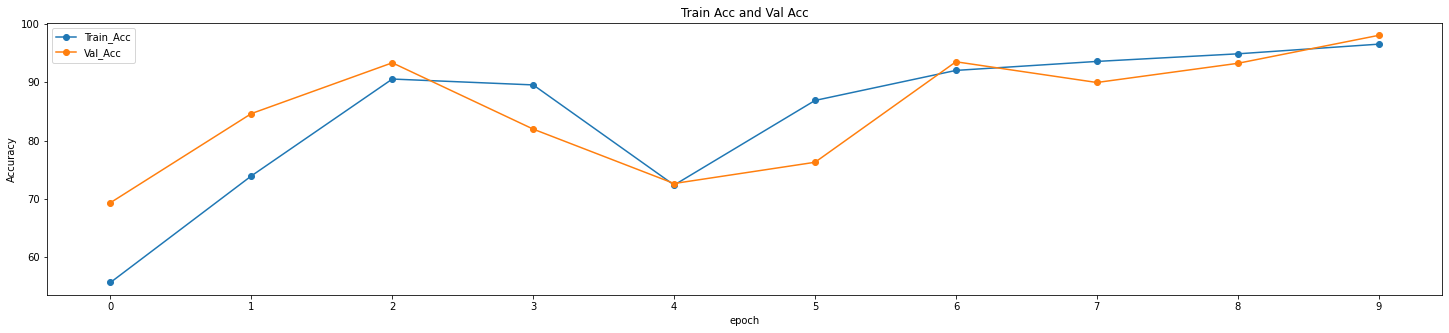

In [20]:
plt.figure(figsize=(25,5))
plt.plot(train_acc_history,'-o')
plt.plot(val_acc_history,'-o')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.legend(['Train_Acc','Val_Acc'])
plt.title('Train Acc and Val Acc')
plt.show()

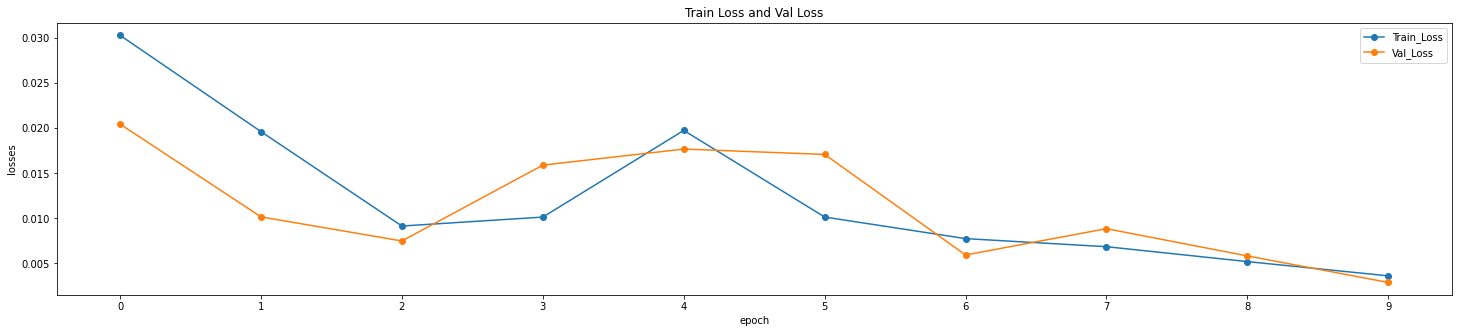

In [21]:
plt.figure(figsize=(25,5))
plt.plot(train_loss_history,'-o')
plt.plot(val_loss_history,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.legend(['Train_Loss','Val_Loss'])
plt.title('Train Loss and Val Loss')
plt.show()

In [22]:
def evaluate_model(model, loader):
    model.eval()
    pred_list = []
    label_list = []
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        running_loss=0
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            _, predictions = torch.max(outputs, 1)
            pred_list.extend(predictions.cpu().numpy())
            label_list.extend(labels.cpu().numpy())
            n_samples += labels.shape[0]
            n_correct += (predictions == labels).sum().item()
        acc = 100.0 * n_correct / n_samples
    return acc,pred_list,label_list

In [23]:
acc, pred_list,label_list = evaluate_model(model, test_loader)
print(f'Accuracy of the network on the test images: {acc} %')

Accuracy of the network on the test images: 97.24933451641526 %
